In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
# GPUs config
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus) # Looks like we have one GPU, nice!
# Config for GPU memory growth if needed
tf.config.experimental.set_memory_growth(gpus[0], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [62]:
np.random.seed(42)
n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]
print(X_train.shape, y_train.shape)

(7000, 50, 1) (7000, 1)


In [5]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

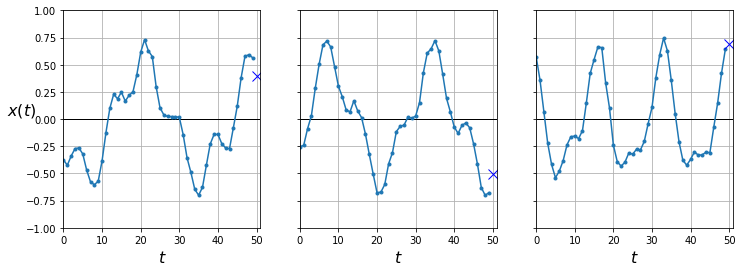

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None))
plt.show()

In [7]:
# Naive forcasting, simply predict the newest value as the last seen value
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.020211367

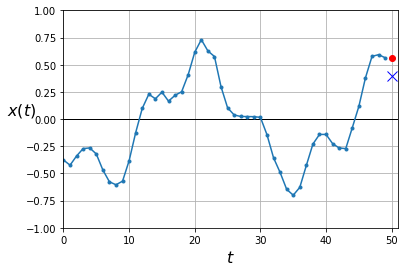

In [8]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

In [9]:
# Linear regression using a neural network
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 2s 329us/sample - loss: 0.1008 - val_loss: 0.0552
Epoch 2/20
7000/7000 [==============================] - 1s 93us/sample - loss: 0.0388 - val_loss: 0.0270
Epoch 3/20
7000/7000 [==============================] - 1s 88us/sample - loss: 0.0206 - val_loss: 0.0160
Epoch 4/20
7000/7000 [==============================] - 1s 83us/sample - loss: 0.0132 - val_loss: 0.0115
Epoch 5/20
7000/7000 [==============================] - 1s 84us/sample - loss: 0.0103 - val_loss: 0.0097
Epoch 6/20
7000/7000 [==============================] - 1s 94us/sample - loss: 0.0089 - val_loss: 0.0087
Epoch 7/20
7000/7000 [==============================] - 1s 87us/sample - loss: 0.0079 - val_loss: 0.0078
Epoch 8/20
7000/7000 [==============================] - 1s 88us/sample - loss: 0.0072 - val_loss: 0.0073
Epoch 9/20
7000/7000 [==============================] - 1s 88us/sample - loss: 0.0066 - val_loss: 0.0066
Epoch 

In [10]:
model.evaluate(X_valid, y_valid)

2000/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0.004112337179481983

In [11]:
y_pred = model.predict(X_valid)
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.0041123373

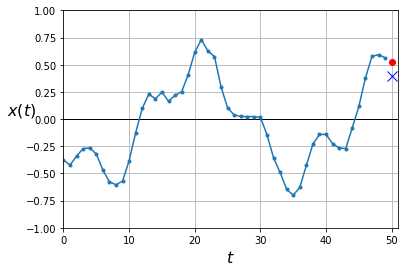

In [12]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

In [13]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

optimizer = keras.optimizers.Adam(lr=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 6s 928us/sample - loss: 0.0979 - val_loss: 0.0490
Epoch 2/20
7000/7000 [==============================] - 5s 753us/sample - loss: 0.0371 - val_loss: 0.0297
Epoch 3/20
7000/7000 [==============================] - 5s 729us/sample - loss: 0.0254 - val_loss: 0.0219
Epoch 4/20
7000/7000 [==============================] - 5s 768us/sample - loss: 0.0199 - val_loss: 0.0177
Epoch 5/20
7000/7000 [==============================] - 6s 875us/sample - loss: 0.0166 - val_loss: 0.0151
Epoch 6/20
7000/7000 [==============================] - 6s 842us/sample - loss: 0.0146 - val_loss: 0.0135
Epoch 7/20
7000/7000 [==============================] - 6s 836us/sample - loss: 0.0133 - val_loss: 0.0124
Epoch 8/20
7000/7000 [==============================] - 6s 842us/sample - loss: 0.0124 - val_loss: 0.0117
Epoch 9/20
7000/7000 [==============================] - 6s 841us/sample - loss: 0.0119 - val_loss: 0.011

In [14]:
model.evaluate(X_valid, y_valid)

2000/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0.010903828285634517

In [15]:
y_pred = model.predict(X_valid)
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.010903829

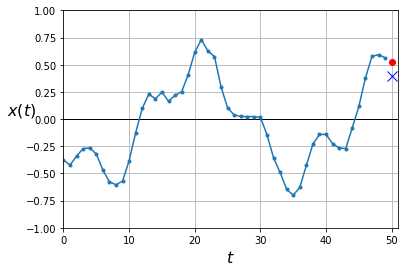

In [16]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

In [17]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 18s 3ms/sample - loss: 0.0531 - val_loss: 0.0083
Epoch 2/20
7000/7000 [==============================] - 16s 2ms/sample - loss: 0.0074 - val_loss: 0.0055
Epoch 3/20
7000/7000 [==============================] - 17s 2ms/sample - loss: 0.0054 - val_loss: 0.0050
Epoch 4/20
7000/7000 [==============================] - 18s 3ms/sample - loss: 0.0047 - val_loss: 0.0041
Epoch 5/20
7000/7000 [==============================] - 18s 3ms/sample - loss: 0.0044 - val_loss: 0.0041
Epoch 6/20
7000/7000 [==============================] - 16s 2ms/sample - loss: 0.0041 - val_loss: 0.0040
Epoch 7/20
7000/7000 [==============================] - 17s 2ms/sample - loss: 0.0038 - val_loss: 0.0035
Epoch 8/20
7000/7000 [==============================] - 17s 2ms/sample - loss: 0.0038 - val_loss: 0.0039
Epoch 9/20
7000/7000 [==============================] - 16s 2ms/sample - loss: 0.0036 - val_loss: 0.0036
Epoch 1

In [18]:
model.evaluate(X_valid, y_valid)

2000/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0.0031113309878855943

In [19]:
y_pred = model.predict(X_valid)
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.003111331

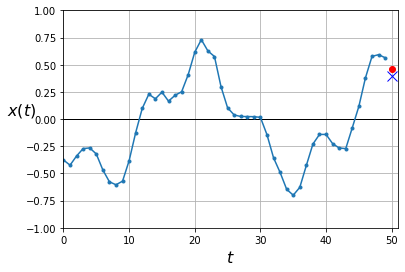

In [20]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

In [63]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0240 - val_loss: 0.0050
Epoch 2/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0043 - val_loss: 0.0035
Epoch 3/20
7000/7000 [==============================] - 10s 1ms/sample - loss: 0.0036 - val_loss: 0.0033
Epoch 4/20
7000/7000 [==============================] - 10s 1ms/sample - loss: 0.0034 - val_loss: 0.0032
Epoch 5/20
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0032 - val_loss: 0.0030
Epoch 6/20
7000/7000 [==============================] - 10s 1ms/sample - loss: 0.0032 - val_loss: 0.0034
Epoch 7/20
7000/7000 [==============================] - 10s 1ms/sample - loss: 0.0031 - val_loss: 0.0028
Epoch 8/20
7000/7000 [==============================] - 10s 1ms/sample - loss: 0.0030 - val_loss: 0.0031
Epoch 9/20
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0030 - val_loss: 0.0031
Epoch 10/20

In [64]:
model.evaluate(X_valid, y_valid)

2000/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0.0028335099183022976

In [65]:
y_pred = model.predict(X_valid)
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.0028335098

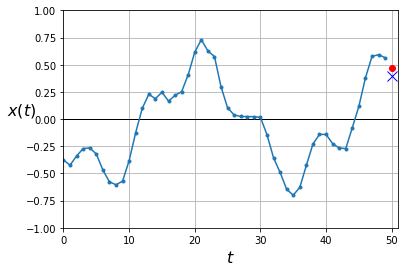

In [66]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

In [67]:
np.random.seed(43) # not 42, as it would give the first series in the train set

series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new

In [68]:
X.shape

(1, 50, 1)

In [69]:
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :] # Turn (1,1) to (1,1,1)
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]

In [70]:
Y_pred.shape

(1, 10, 1)

In [71]:
X.shape

(1, 60, 1)

In [72]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "ro-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "bx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

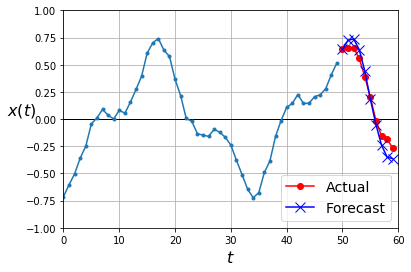

In [73]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

In [74]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

In [75]:
print(series.shape)
print(X_test.shape)
print(Y_test.shape)

(10000, 60, 1)
(1000, 50, 1)
(1000, 10)


In [76]:
X = X_valid
for step_ahead in range(10):
    y_pred_one = model.predict(X)[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:, 0]
print(Y_pred.shape)

(2000, 10)


In [81]:
(keras.metrics.mean_squared_error(Y_valid, Y_pred)).shape

TensorShape([2000])

In [82]:
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_pred))

0.025828129

In [83]:
Y_naive_pred = Y_valid[:, -1:]
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_naive_pred))

0.22278848

In [87]:
Y_valid.shape

(2000, 10)

In [88]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 1s 101us/sample - loss: 0.1335 - val_loss: 0.0605
Epoch 2/20
7000/7000 [==============================] - 1s 73us/sample - loss: 0.0498 - val_loss: 0.0424
Epoch 3/20
7000/7000 [==============================] - 0s 71us/sample - loss: 0.0385 - val_loss: 0.0354
Epoch 4/20
7000/7000 [==============================] - 1s 73us/sample - loss: 0.0332 - val_loss: 0.0313
Epoch 5/20
7000/7000 [==============================] - 1s 72us/sample - loss: 0.0298 - val_loss: 0.0282
Epoch 6/20
7000/7000 [==============================] - 1s 73us/sample - loss: 0.0274 - val_loss: 0.0264
Epoch 7/20
7000/7000 [==============================] - 0s 71us/sample - loss: 0.0257 - val_loss: 0.0249
Epoch 8/20
7000/7000 [==============================] - 1s 73us/sample - loss: 0.0244 - val_loss: 0.0240
Epoch 9/20
7000/7000 [==============================] - 1s 72us/sample - loss: 0.0235 - val_loss: 0.0229
Epoch 

In [47]:
# Predicts all targets at once
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0663 - val_loss: 0.0312
Epoch 2/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0265 - val_loss: 0.0214
Epoch 3/20
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0187 - val_loss: 0.0203
Epoch 4/20
7000/7000 [==============================] - 10s 1ms/sample - loss: 0.0151 - val_loss: 0.0157
Epoch 5/20
7000/7000 [==============================] - 10s 1ms/sample - loss: 0.0139 - val_loss: 0.0127
Epoch 6/20
7000/7000 [==============================] - 11s 2ms/sample - loss: 0.0127 - val_loss: 0.0114
Epoch 7/20
7000/7000 [==============================] - 11s 2ms/sample - loss: 0.0119 - val_loss: 0.0118
Epoch 8/20
7000/7000 [==============================] - 10s 1ms/sample - loss: 0.0114 - val_loss: 0.0106
Epoch 9/20
7000/7000 [==============================] - 10s 1ms/sample - loss: 0.0110 - val_loss: 0.0116
Epoch 10/2

In [59]:
model.evaluate(X_valid, Y_valid)

2000/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0.007976172015070915

In [55]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]

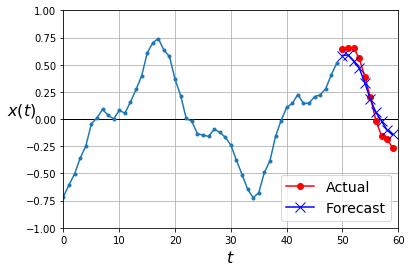

In [56]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

In [95]:
np.random.seed(42)
n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
print(series.shape)
print(Y.shape)

(10000, 60, 1)
(10000, 50, 10)


In [96]:
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [97]:
print(Y_train.shape)
print(Y_valid.shape)
print(Y_test.shape)

(7000, 50, 10)
(2000, 50, 10)
(1000, 50, 10)


In [98]:
X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 50, 10))

In [99]:
Y_train[:, -1].shape

(7000, 10)

In [100]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10)) # Applies Dense(10) at every time step
])

def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="mse", optimizer=keras.optimizers.Adam(lr=0.01), metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 10s 1ms/sample - loss: 0.0502 - last_time_step_mse: 0.0392 - val_loss: 0.0422 - val_last_time_step_mse: 0.0309
Epoch 2/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0403 - last_time_step_mse: 0.0293 - val_loss: 0.0361 - val_last_time_step_mse: 0.0274
Epoch 3/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0406 - last_time_step_mse: 0.0340 - val_loss: 0.0339 - val_last_time_step_mse: 0.0247
Epoch 4/20
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0329 - last_time_step_mse: 0.0228 - val_loss: 0.0292 - val_last_time_step_mse: 0.0186
Epoch 5/20
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0285 - last_time_step_mse: 0.0174 - val_loss: 0.0271 - val_last_time_step_mse: 0.0161
Epoch 6/20
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0249 - last_time_step_mse: 0.0132 - val_l

In [101]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

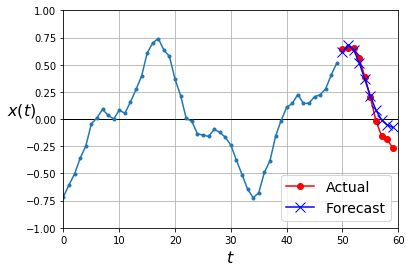

In [102]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

In [105]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.BatchNormalization(),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.BatchNormalization(),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 12s 2ms/sample - loss: 0.1935 - last_time_step_mse: 0.1917 - val_loss: 0.0902 - val_last_time_step_mse: 0.0864
Epoch 2/20
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0535 - last_time_step_mse: 0.0447 - val_loss: 0.0556 - val_last_time_step_mse: 0.0468
Epoch 3/20
7000/7000 [==============================] - 11s 2ms/sample - loss: 0.0470 - last_time_step_mse: 0.0374 - val_loss: 0.0453 - val_last_time_step_mse: 0.0357
Epoch 4/20
7000/7000 [==============================] - 11s 2ms/sample - loss: 0.0436 - last_time_step_mse: 0.0335 - val_loss: 0.0417 - val_last_time_step_mse: 0.0320
Epoch 5/20
7000/7000 [==============================] - 11s 2ms/sample - loss: 0.0408 - last_time_step_mse: 0.0304 - val_loss: 0.0405 - val_last_time_step_mse: 0.0301
Epoch 6/20
7000/7000 [==============================] - 10s 1ms/sample - loss: 0.0385 - last_time_step_mse: 0.0277 - v

In [106]:
from tensorflow.keras.layers import LayerNormalization
class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units,
                                                          activation=None)
        self.layer_norm = LayerNormalization()
        self.activation = keras.activations.get(activation)
    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        if inputs is not None:
            batch_size = tf.shape(inputs)[0]
            dtype = inputs.dtype
        return [tf.zeros([batch_size, self.state_size], dtype=dtype)]
    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [107]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True,
                     input_shape=[None, 1]),
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 28s 4ms/sample - loss: 0.1608 - last_time_step_mse: 0.1580 - val_loss: 0.0728 - val_last_time_step_mse: 0.0652
Epoch 2/20
7000/7000 [==============================] - 26s 4ms/sample - loss: 0.0641 - last_time_step_mse: 0.0528 - val_loss: 0.0585 - val_last_time_step_mse: 0.0456
Epoch 3/20
7000/7000 [==============================] - 28s 4ms/sample - loss: 0.0556 - last_time_step_mse: 0.0431 - val_loss: 0.0527 - val_last_time_step_mse: 0.0398
Epoch 4/20
7000/7000 [==============================] - 27s 4ms/sample - loss: 0.0501 - last_time_step_mse: 0.0382 - val_loss: 0.0472 - val_last_time_step_mse: 0.0360
Epoch 5/20
7000/7000 [==============================] - 28s 4ms/sample - loss: 0.0457 - last_time_step_mse: 0.0348 - val_loss: 0.0432 - val_last_time_step_mse: 0.0314
Epoch 6/20
7000/7000 [==============================] - 28s 4ms/sample - loss: 0.0415 - last_time_step_mse: 0.0306 - 

In [108]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0766 - last_time_step_mse: 0.0628 - val_loss: 0.0555 - val_last_time_step_mse: 0.0371
Epoch 2/20
7000/7000 [==============================] - 3s 448us/sample - loss: 0.0480 - last_time_step_mse: 0.0284 - val_loss: 0.0426 - val_last_time_step_mse: 0.0223
Epoch 3/20
7000/7000 [==============================] - 3s 445us/sample - loss: 0.0391 - last_time_step_mse: 0.0186 - val_loss: 0.0375 - val_last_time_step_mse: 0.0173
Epoch 4/20
7000/7000 [==============================] - 3s 440us/sample - loss: 0.0352 - last_time_step_mse: 0.0154 - val_loss: 0.0334 - val_last_time_step_mse: 0.0133
Epoch 5/20
7000/7000 [==============================] - 3s 441us/sample - loss: 0.0327 - last_time_step_mse: 0.0134 - val_loss: 0.0316 - val_last_time_step_mse: 0.0124
Epoch 6/20
7000/7000 [==============================] - 3s 427us/sample - loss: 0.0311 - last_time_step_mse: 0.012

In [109]:
model.evaluate(X_valid, Y_valid)

2000/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.02375690922141075, 0.008638693]

In [110]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

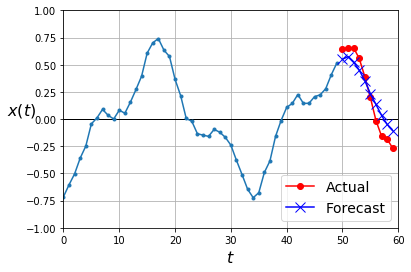

In [111]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

In [112]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 6s 797us/sample - loss: 0.0745 - last_time_step_mse: 0.0668 - val_loss: 0.0526 - val_last_time_step_mse: 0.0413
Epoch 2/20
7000/7000 [==============================] - 3s 419us/sample - loss: 0.0478 - last_time_step_mse: 0.0369 - val_loss: 0.0441 - val_last_time_step_mse: 0.0326
Epoch 3/20
7000/7000 [==============================] - 3s 419us/sample - loss: 0.0420 - last_time_step_mse: 0.0306 - val_loss: 0.0395 - val_last_time_step_mse: 0.0275
Epoch 4/20
7000/7000 [==============================] - 3s 414us/sample - loss: 0.0375 - last_time_step_mse: 0.0250 - val_loss: 0.0346 - val_last_time_step_mse: 0.0205
Epoch 5/20
7000/7000 [==============================] - 3s 421us/sample - loss: 0.0327 - last_time_step_mse: 0.0178 - val_loss: 0.0311 - val_last_time_step_mse: 0.0156
Epoch 6/20
7000/7000 [==============================] - 3s 421us/sample - loss: 0.0309 - last_time_step_mse: 0.0

In [113]:
model.evaluate(X_valid, Y_valid)

2000/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.024027098193764685, 0.010358044]

In [114]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

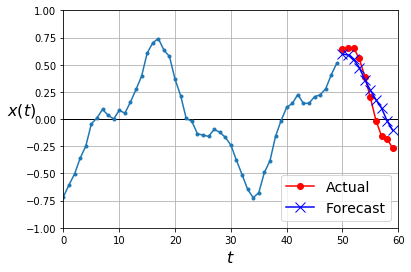

In [115]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

In [118]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",
                        input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train[:, 3::2], epochs=20,
                    validation_data=(X_valid, Y_valid[:, 3::2]))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 5s 708us/sample - loss: 0.0686 - last_time_step_mse: 0.0609 - val_loss: 0.0485 - val_last_time_step_mse: 0.0406
Epoch 2/20
7000/7000 [==============================] - 2s 282us/sample - loss: 0.0420 - last_time_step_mse: 0.0346 - val_loss: 0.0370 - val_last_time_step_mse: 0.0290
Epoch 3/20
7000/7000 [==============================] - 2s 282us/sample - loss: 0.0341 - last_time_step_mse: 0.0262 - val_loss: 0.0307 - val_last_time_step_mse: 0.0215
Epoch 4/20
7000/7000 [==============================] - 2s 272us/sample - loss: 0.0282 - last_time_step_mse: 0.0183 - val_loss: 0.0258 - val_last_time_step_mse: 0.0149
Epoch 5/20
7000/7000 [==============================] - 2s 277us/sample - loss: 0.0249 - last_time_step_mse: 0.0143 - val_loss: 0.0239 - val_last_time_step_mse: 0.0130
Epoch 6/20
7000/7000 [==============================] - 2s 271us/sample - loss: 0.0236 - last_time_step_mse: 0.0

In [122]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=10, kernel_size=1))
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 4s 509us/sample - loss: 0.0668 - last_time_step_mse: 0.0541 - val_loss: 0.0362 - val_last_time_step_mse: 0.0225
Epoch 2/20
7000/7000 [==============================] - 1s 161us/sample - loss: 0.0321 - last_time_step_mse: 0.0196 - val_loss: 0.0307 - val_last_time_step_mse: 0.0191
Epoch 3/20
7000/7000 [==============================] - 1s 176us/sample - loss: 0.0279 - last_time_step_mse: 0.0159 - val_loss: 0.0268 - val_last_time_step_mse: 0.0147
Epoch 4/20
7000/7000 [==============================] - 1s 162us/sample - loss: 0.0259 - last_time_step_mse: 0.0140 - val_loss: 0.0249 - val_last_time_step_mse: 0.0126
Epoch 5/20
7000/7000 [==============================] - 1s 163us/sample - loss: 0.0248 - last_time_step_mse: 0.0131 - val_loss: 0.0241 - val_last_time_step_mse: 0.0120
Epoch 6/20
7000/7000 [==============================] - 1s 162us/sample - loss: 0.0240 - last_time_step_mse: 0.0